Notebook to generate semisynthetic CML data from a RADOLAN image and to reconstruct fields from this data using Random Mixing.

# Import

In [1]:
import os
import sys

fpth = os.path.abspath(os.path.join('..','RMWSPy', 'cml_example'))
sys.path.append(fpth)
fpth = os.path.abspath(os.path.join('..','RMWSPy', 'rmwspy'))
sys.path.append(fpth)

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

import dask
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

import sparse

# copied from pycomlink to aviod dowloading conflicting libraries
from grid_intersection import get_grid_time_series_at_intersections
from grid_intersection import calc_sparse_intersect_weights_for_several_cmls
from grid_intersection import calc_intersect_weights

import datetime
from tqdm import tqdm
import yaml

import rain_data as cmlp
import RM_processing as rmp
from cml import *

import CRPS.CRPS as pscore

%load_ext autoreload
%autoreload 2

In [2]:
erlend_pth = os.path.abspath(os.path.join('..','..'))
sys.path.append(erlend_pth)
from RM_processing import create_blocks_from_lines
from RM_processing import generate_cmls_grid_intersects

from scipy.stats import norm
import gstools as gs
import os, shutil

# supress warnings from shapely
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
import pickle

In [3]:
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as tkr
from matplotlib.ticker import FormatStrFormatter

# prepare CML and rain gauge data

In [4]:
ds_rad = xr.open_dataset('./data/openMRG_example_rad.nc', engine='netcdf4')

In [5]:
# load radar data from sandbox repository
ds_rad = xr.open_dataset('./data/openMRG_example_rad.nc').rename( # create using notebook in data folder
    {'rainfall':'rainfall_amount',
     'lat':'latitudes',
     'lon':'longitudes'
    }
).transpose('time', 'y', 'x')

grid_point_location='center' 

# flip to work in the grid intersection function
ds_rad['latitudes'] = (('y', 'x'), np.flip(ds_rad.latitudes.values, axis = 0)) 
ds_rad['rainfall_amount'] = (('time', 'y', 'x'), np.flip(ds_rad.rainfall_amount.values, axis = 1))

# convert to sum 5 min
ds_rad['rainfall_amount'] = ds_rad.rainfall_amount*(5/60)

In [6]:
# read gauge data from CSV and store to xarray, copied from Graf compare article
df_gauge = pd.read_csv('./data/andersson_2022_OpenMRG/gauges/city/CityGauges-2015JJA.csv',
                            index_col=0,
                           parse_dates=True
                           )
df_gauge_meta = pd.read_csv('./data/andersson_2022_OpenMRG/gauges/city/CityGauges-metadata.csv')

# 
ds_gauges = xr.Dataset(
    data_vars=dict(
        rainfall_amount=(["station_id", "time"], df_gauge.T),
    ),
    coords=dict(
        station_id=df_gauge_meta.index.values,
        time=df_gauge.index.values,
        lon=(["station_id"], df_gauge_meta.Longitude_DecDeg),
        lat=(["station_id"], df_gauge_meta.Latitude_DecDeg),
        location=(["station_id"], df_gauge_meta.Location),
        type=(["station_id"], df_gauge_meta.Type),
        quantization=(["station_id"], df_gauge_meta["Resolution (mm)"]),
    ),
)
# shorten and resample to sum 5 min
ds_gauges = ds_gauges.sel(time = slice(ds_rad.time[0], ds_rad.time[-1])).resample(time="5min").sum()

In [7]:
# read CML data
ds_cml = xr.open_dataset('./data/ds_cml_ompenmrg.nc').rename(
    {'site_0_lat':'site_a_latitude',
     'site_0_lon':'site_a_longitude',
     'site_1_lat':'site_b_latitude',
     'site_1_lon':'site_b_longitude',
    }
)

# shorten time span to match radar
ds_cml = ds_cml.sel(time = ds_rad.time)

# drop CMLs with nan, a bit restrictive but we have many CMLs here
ds_cml = ds_cml.where(~np.isnan(ds_cml.R).any(dim = 'time'), drop = True)

In [8]:
# shorten time
ds_cml = ds_cml.sel(time = slice('2015-07-25T12', '2015-07-25T15'))
ds_gauges = ds_gauges.sel(time = slice('2015-07-25T12', '2015-07-25T15'))
ds_rad = ds_rad.sel(time = slice('2015-07-25T12', '2015-07-25T15'))

In [9]:
# Delay grids to allow dask to track them
lats = dask.delayed(ds_rad.latitudes.load())
lons = dask.delayed(ds_rad.longitudes.load())

intersec_weights_list = []
cml_id_list = []

for cml_id, cml in tqdm(ds_cml.isel(time = 0).groupby("cml_id")):
    cml_id_list.append(cml_id)
    intersec_weights_list.append(
        dask.delayed(sparse.COO.from_numpy)(
            dask.delayed(calc_intersect_weights)(
                # dask.delayed(calc_intersect_weights)(
                x1_line=cml.site_a_longitude,
                y1_line=cml.site_a_latitude,
                x2_line=cml.site_b_longitude,
                y2_line=cml.site_b_latitude,
                x_grid=lons,  
                y_grid=lats,  
                grid_point_location=grid_point_location,
            )
        )
    )

  0%|                                                          | 0/337 [00:00<?, ?it/s]/home/erlend/miniforge3/envs/geospatial/lib/python3.10/site-packages/tqdm/std.py:1181: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for obj in iterable:
100%|██████████████████████████████████████████████| 337/337 [00:00<00:00, 1194.86it/s]


In [10]:
intersec_weights_list = dask.compute(*intersec_weights_list)

# create mask with info whether a cml is on the rad grid
covered_by_rad_grid = []
for weight in tqdm(intersec_weights_list):
    if weight.sum() == 0:
        covered_by_rad_grid.append(False)
    elif weight.sum() > 0:
        covered_by_rad_grid.append(True)

da_intersec_weights_list = []
for cml_id, intersec_weights in zip(cml_id_list, intersec_weights_list):
    coords = ds_rad.isel(time = 0).coords
    coords["cml_id"] = cml_id
    da_intersec_weights_list.append(
        xr.DataArray(
            dims=("y", "x"),  
            coords=coords,
            data=intersec_weights,
        )
    )

da_intersec_weights = xr.concat(da_intersec_weights_list, dim="cml_id")

100%|████████████████████████████████████████████████| 337/337 [00:03<00:00, 88.85it/s]


In [11]:
# for time coordinates: 
cmls = []
for time in ds_rad.time.values.copy():
    # create new dataset for path averages
    ds_gridded_along_cml = xr.Dataset(
        coords={
            "time": time,
            "cml_id": da_intersec_weights.cml_id,
        },
    )
    
    # create path averages
    temp_list = []
    temp = dask.array.tensordot(
        ds_rad.sel(time = time).rainfall_amount.data, da_intersec_weights.data, axes=[[0, 1], [1, 2]]
    )
    ds_gridded_along_cml["R"] = ["cml_id"], temp.compute()    
    
    # Add CML coordinates (adding one dataset coordinate adds all the others)
    ds_gridded_along_cml.coords["site_a_latitude"] = ds_cml.site_a_latitude
    # add info whether link is in the area that is covered by the gridded data
    ds_gridded_along_cml["covered_by_rad_grid"] = ("cml_id", covered_by_rad_grid)

    # Erlend: Changed this line to avoid error
    ds_gridded_along_cml["covered_by_rad_reach"] = (
        "cml_id",
        (~ds_gridded_along_cml.R.isnull() & ds_gridded_along_cml.covered_by_rad_grid).values
    )
    
    cmls.append(ds_gridded_along_cml)
ds_gridded_along_cml = xr.concat(cmls, dim = 'time')

# dask seem to sett all time to last timestep? this fixes that. 
ds_gridded_along_cml['time'] = ds_rad.time

In [12]:
ds_cml['R_rad'] = (('time', 'cml_id'), ds_gridded_along_cml.R.values)

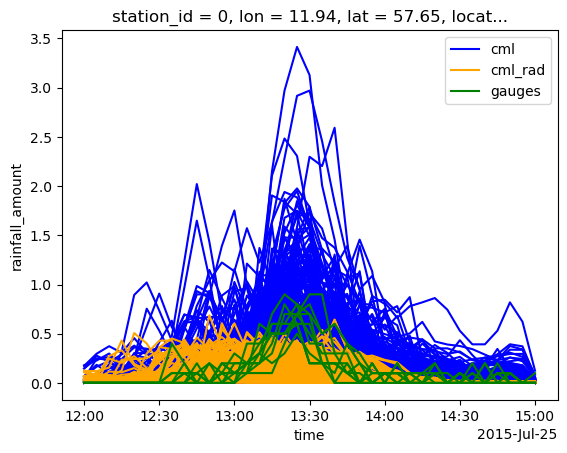

In [13]:
ds_cml.R.plot.line(x = 'time', add_legend= False, color = 'blue');
ds_cml.R.isel(cml_id = 0).plot.line(x = 'time', add_legend= False, color = 'blue', label = 'cml');

ds_cml.R_rad.plot.line(x = 'time', add_legend= False, color = 'orange');
ds_cml.R_rad.isel(cml_id = 0).plot.line(x = 'time', add_legend= False, color = 'orange', label = 'cml_rad');

ds_gauges.rainfall_amount.plot.line(x = 'time', add_legend= False, color = 'green');

ds_gauges.isel(station_id = 0).rainfall_amount.plot.line(x = 'time', add_legend= False, color = 'green', label = 'gauges');

plt.legend()

# Resample time

In [14]:
# resample to 5 min resolution to match gauge resolution
ds_cml = ds_cml.resample(time = '5T').sum()
ds_gauges = ds_gauges.resample(time = '5T').sum()
ds_rad =  ds_rad.resample(time = '5T').sum()

/home/erlend/miniforge3/envs/geospatial/lib/python3.10/site-packages/xarray/core/groupby.py:532: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  index_grouper = pd.Grouper(
/home/erlend/miniforge3/envs/geospatial/lib/python3.10/site-packages/xarray/core/groupby.py:532: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  index_grouper = pd.Grouper(
/home/erlend/miniforge3/envs/geospatial/lib/python3.10/site-packages/xarray/core/groupby.py:532: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  index_grouper = pd.Grouper(


In [15]:
# quickfix dimensions 
ds_rad['crs'] = ds_rad.crs.isel(time = 0)
ds_rad['latitudes'] = ds_rad.latitudes.isel(time = 0)
ds_rad['longitudes'] = ds_rad.longitudes.isel(time = 0)

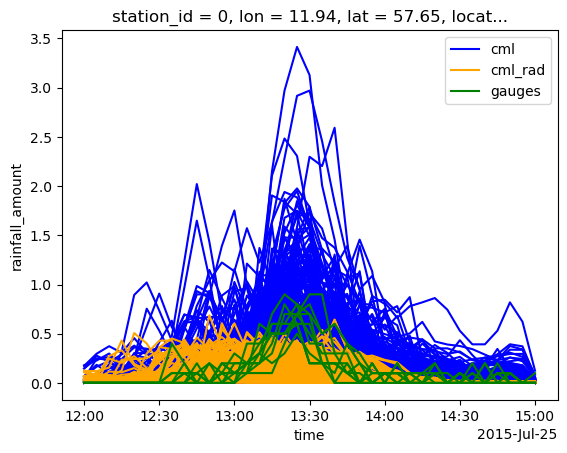

In [16]:
ds_cml.R.plot.line(x = 'time', add_legend= False, color = 'blue');
ds_cml.R.isel(cml_id = 0).plot.line(x = 'time', add_legend= False, color = 'blue', label = 'cml');

ds_cml.R_rad.plot.line(x = 'time', add_legend= False, color = 'orange');
ds_cml.R_rad.isel(cml_id = 0).plot.line(x = 'time', add_legend= False, color = 'orange', label = 'cml_rad');

ds_gauges.rainfall_amount.plot.line(x = 'time', add_legend= False, color = 'green');

ds_gauges.isel(station_id = 0).rainfall_amount.plot.line(x = 'time', add_legend= False, color = 'green', label = 'gauges');

plt.legend()

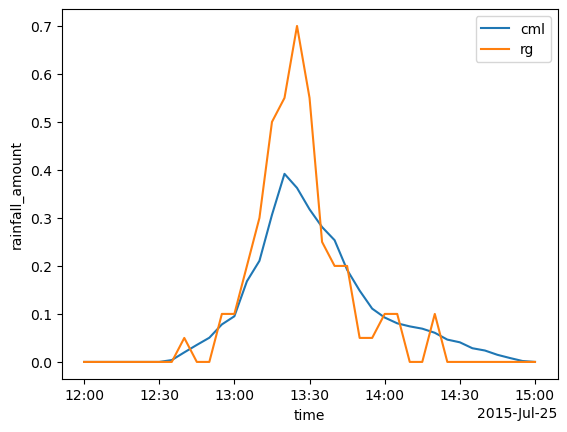

In [17]:
ds_cml.R.median(dim = 'cml_id').plot(label = 'cml')
ds_gauges.rainfall_amount.median(dim = 'station_id').plot(label = 'rg')
plt.legend()

# Use CML data in RM algorithm
Here I use the CML data in all steps. CML midpoints are used for the estimation of the spatial model, the transformation function, and (optional, see flag `linear_constraints`) as linear constraints. CML paths are still considered at the end as nonlinear constraints.

**Note that I remove several CMLs.** The reason is that it is not possible (singular matrix) to estimate the spatial model with observations on the same grid point. I remove them completely now, though it would be possible to use them as nonlinear constraints still.

In [18]:
# define options
lin_constraints = False             # whether linear constraints should be considered
nonlin_constraints = True           # whether nonlinear constraints should be considered
nfields = 4                         # number of ensemble members
maskR = None                        # special functionality with masking, should always be None here
outfolder = "../../data/fields/"    # path to output folder

In [19]:
from pyproj import CRS
from pyproj import Transformer

In [20]:
#ds_cml = xr.open_dataset("./data/cml_rain_from_rad.nc",)
#ds_rad = xr.open_dataset("./data/ds_rad.nc")

In [21]:
crs = CRS('EPSG:32632') # Norway: EPSG:32632, Sweden: 32633
crs_source = CRS('EPSG:4326') # latitude longitude wgs84

# Create Transformer to convert from geodetic CRS to CRS: https://pyproj4.github.io/pyproj/stable/examples.html
proj = Transformer.from_crs(crs_source, crs, always_xy=True)

In [22]:
site_a_x, site_a_y = proj.transform(ds_cml.site_a_longitude, ds_cml.site_a_latitude)
site_b_x, site_b_y = proj.transform(ds_cml.site_b_longitude, ds_cml.site_b_latitude)

ds_cml = ds_cml.assign_coords(x_a = ("cml_id", site_a_x))
ds_cml = ds_cml.assign_coords(y_a = ("cml_id", site_a_y))
ds_cml = ds_cml.assign_coords(x_b = ("cml_id", site_b_x))
ds_cml = ds_cml.assign_coords(y_b = ("cml_id", site_b_y))
                              
ds_cml = ds_cml.assign_coords(x = ("cml_id", np.mean([site_a_x.reshape(-1, 1), site_b_x.reshape(-1, 1)], axis = 0).ravel()))
ds_cml = ds_cml.assign_coords(y = ("cml_id", np.mean([site_a_y.reshape(-1, 1), site_b_y.reshape(-1, 1)], axis = 0).ravel()))

In [23]:
# convert gauges to cml coordinate system
gau_x, gau_y = proj.transform(ds_gauges.lon, ds_gauges.lat)
ds_gauges = ds_gauges.assign_coords(x = ("station_id", gau_x))
ds_gauges = ds_gauges.assign_coords(y = ("station_id", gau_y))

In [24]:
# create grid based on CML possitions:
offset = 500 # meter to the side
gridsize = 250 # meter per grid cell
# xgrid = np.arange(np.min([ds_cml.x_a, ds_cml.x_b]) - offset, 
#                   np.max([ds_cml.x_a, ds_cml.x_b]) + offset, gridsize).astype(int)
# ygrid = np.arange(np.min([ds_cml.y_a, ds_cml.y_b]) - offset, 
#                   np.max([ds_cml.y_a, ds_cml.y_b]) + offset, gridsize).astype(int)

xgrid = np.arange(ds_gauges.x.min() - offset, ds_gauges.x.max() + offset, gridsize).astype(int)
ygrid = np.arange(ds_gauges.y.min() - offset, ds_gauges.y.max() + offset, gridsize).astype(int)

In [25]:
ds_cml = ds_cml.where(ds_cml.x_a > xgrid[0], drop= True)
ds_cml = ds_cml.where(ds_cml.x_b > xgrid[0], drop= True)

ds_cml = ds_cml.where(ds_cml.x_a < xgrid[-1], drop= True)
ds_cml = ds_cml.where(ds_cml.x_b < xgrid[-1], drop= True)

ds_cml = ds_cml.where(ds_cml.y_a > ygrid[0], drop= True)
ds_cml = ds_cml.where(ds_cml.y_b > ygrid[0], drop= True)

ds_cml = ds_cml.where(ds_cml.y_a < ygrid[-1], drop= True)
ds_cml = ds_cml.where(ds_cml.y_b < ygrid[-1], drop= True)

In [26]:
# convert radar to cml coordinate system, assign value to closest xgrid value
rad_x, rad_y = proj.transform(ds_rad.longitudes, ds_rad.latitudes)

In [27]:
# array for storing transformed rainfall values, these are only used for visualization inside this notebook
rad_imgs = np.zeros([ds_rad.time.size, ygrid.size, xgrid.size])
cml_imgs = np.zeros([ds_rad.time.size, ygrid.size, xgrid.size])

for t in tqdm(range(ds_rad.time.size)): #
    for y_ind in range(ygrid.size):
        for x_ind in range(xgrid.size):
            
            # compute distances to all radar points
            distances = (rad_x - xgrid[x_ind])**2 + (rad_y - ygrid[y_ind])**2
            
            # find possition of closes point in grid
            index = np.argmin(distances) 
            y_rad_ind, x_rad_ind = np.unravel_index(index, distances.shape)
            
            # get closest radar value for this point
            rad_imgs[t, y_ind, x_ind] = ds_rad.rainfall_amount.isel(time = t, y = y_rad_ind, x = x_rad_ind).values
            
            # compute distances to all CML midpoints
            distances = (ds_cml.x - xgrid[x_ind])**2 + (ds_cml.y - ygrid[y_ind])**2
            
            # get closest cml value for this point
            cml_imgs[t, y_ind, x_ind] = ds_cml.R.isel(time = t, cml_id = np.argmin(distances.values) ).values            
            
            

ds_rad_proj = xr.Dataset(
        data_vars= dict(
            rainfall_amount=(['time', 'y', 'x'], rad_imgs), 
            cml_nearest = (['time', 'y', 'x'], cml_imgs), # nearest neighbour interpolation
        ),
        coords=dict(
            time = ds_rad.time,
            y = ygrid,
            x = xgrid
        ),
    ) 

100%|██████████████████████████████████████████████████| 37/37 [09:22<00:00, 15.19s/it]


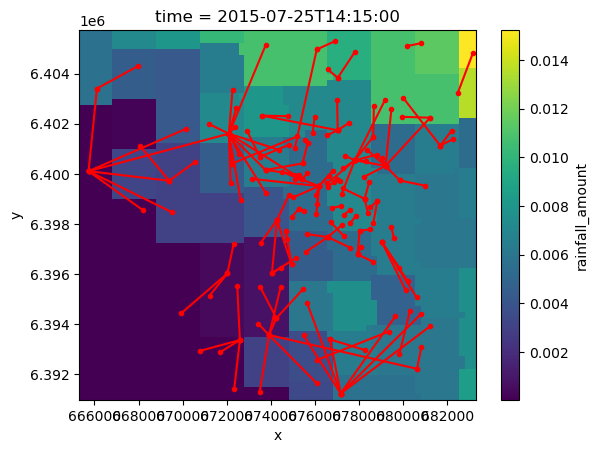

In [28]:
# plot current projection
ds_rad_proj.isel(time = 27).rainfall_amount.plot.imshow()
for device in ds_cml.cml_id:
    plt.plot([device.x_a, device.x_b],[
            device.y_a, device.y_b], '-r', marker='o', markersize =3)

In [29]:
ymin = ds_rad_proj.y.min().values 
xmin = ds_rad_proj.x.min().values
ymax = ds_rad_proj.y.max().values
xmax = ds_rad_proj.x.max().values

# domainsize defined by radolan image (ensure that y is first coordinate of rainfall amount)
domainsize = ds_rad_proj.rainfall_amount.shape

In [30]:
# shift radar: 
ds_rad_proj['y'] = ('y', ((ds_rad_proj.y.values - ymin)/gridsize).astype(int)) # convert to km to make it match indice
ds_rad_proj['x'] = ('x', ((ds_rad_proj.x.values - xmin)/gridsize).astype(int))

# shift gauges
ds_gauges["y"] = ((ds_gauges.y - ygrid[0])/gridsize).astype(int)
ds_gauges["x"] = ((ds_gauges.x - xgrid[0])/gridsize).astype(int)

In [31]:
# shift towards origin
# Now these variables represent both the indice and length between them, they can also be represented in RM? 
ds_cml["y_a"] = ((ds_cml.y_a - ygrid[0])/gridsize).astype(int)
ds_cml["x_a"] = ((ds_cml.x_a - xgrid[0])/gridsize).astype(int)
ds_cml["y_b"] = ((ds_cml.y_b - ygrid[0])/gridsize).astype(int)
ds_cml["x_b"] = ((ds_cml.x_b - xgrid[0])/gridsize).astype(int)

# set midpoint
ds_cml["x"] = ((ds_cml.x_a + ds_cml.x_b)/2).astype(int)
ds_cml["y"] = ((ds_cml.y_a + ds_cml.y_b)/2).astype(int)

In [32]:
# adjust naming conventions
ds_cml = ds_cml.rename({"cml_id": "obs_id"})

In [33]:
# remove observations that fall on the same grid point
ds_cml = cmlp.label_combined_duplicates(ds_cml)
ds_cml = ds_cml.where(ds_cml.label_dupl, drop=True)

# remove some cmls that also are duplicates
ds_cml['duplicate'] = np.logical_and( ds_cml.x_a == ds_cml.x_b, ds_cml.y_a == ds_cml.y_b)
ds_cml['duplicate'] = ds_cml['duplicate'] != 0 # 
ds_cml = ds_cml.where(ds_cml.duplicate == False, drop = True)

### Plot situation:

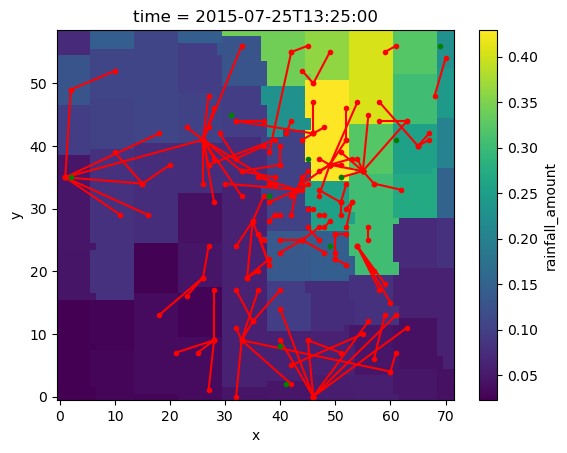

In [34]:
ds_rad_proj.sel(time =  '2015-07-25T13:25').rainfall_amount.plot.imshow()
for device in ds_cml.obs_id:
    plt.plot([device.x_a, device.x_b],[
            device.y_a, device.y_b], '-r', marker='o', markersize =3)
    
for device in ds_gauges.station_id:
    plt.plot(device.x, device.y, 'g', marker='o', markersize =3)

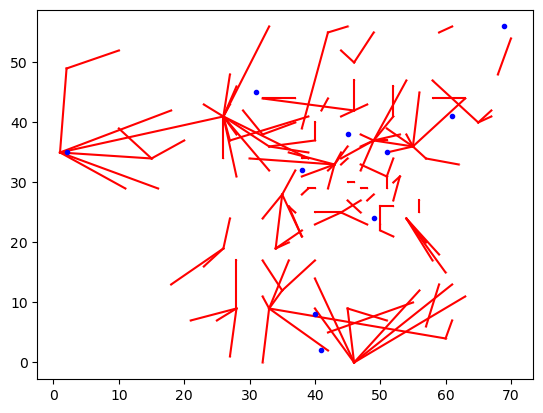

In [35]:
#ds_rad_proj.sel(time = '2015-07-25T13:25').cml_nearest.plot.imshow()
for device in ds_cml.obs_id:
    plt.plot([device.x_a, device.x_b],[
            device.y_a, device.y_b], '-r', marker='o', markersize =0.1)
    
for device in ds_gauges.station_id:
    plt.plot(device.x, device.y, 'blue', marker='o', markersize =3)

### Plot the variogram

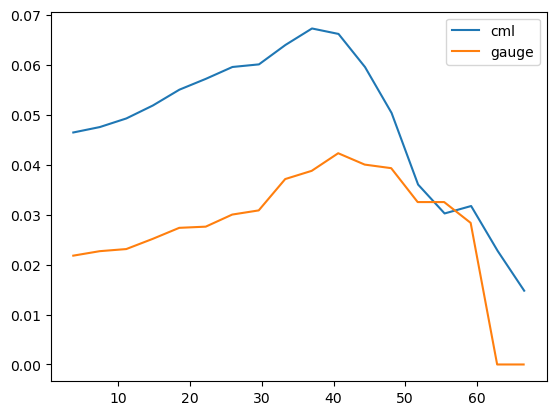

In [36]:
time = '2015-07-25T13:45'
cml_val = ds_cml.sel(time = time).R.values
dist_cml = np.sqrt((ds_cml.x.values - ds_cml.x.values.reshape(-1, 1))**2 + (ds_cml.y.values - ds_cml.y.values.reshape(-1, 1))**2).ravel()
var_cml = (0.5*(cml_val - cml_val.reshape(-1, 1))**2).ravel()

gauge_val = ds_gauges.sel(time = time).rainfall_amount.values
dist_gauge = np.sqrt((ds_gauges.x.values - ds_gauges.x.values.reshape(-1, 1))**2 + (ds_gauges.y.values - ds_gauges.y.values.reshape(-1, 1))**2).ravel()
var_gauge = (0.5*(gauge_val - gauge_val.reshape(-1, 1))**2).ravel()


bins = np.linspace(0, max(dist_cml), 20)
var_bin = []
for i in range(1, bins.size):
    in_bin = (dist_cml > bins[i-1]) & (dist_cml > bins[i])
    var_bin.append(var_cml[in_bin].mean())
plt.plot(bins[1:], var_bin, label = 'cml')

bins = np.linspace(0, max(dist_gauge), 20)
var_bin = []
for i in range(1, bins.size):
    in_bin = (dist_gauge > bins[i-1]) & (dist_gauge > bins[i])
    var_bin.append(var_gauge[in_bin].mean())
plt.plot(bins[1:], var_bin, label = 'gauge')
plt.legend()

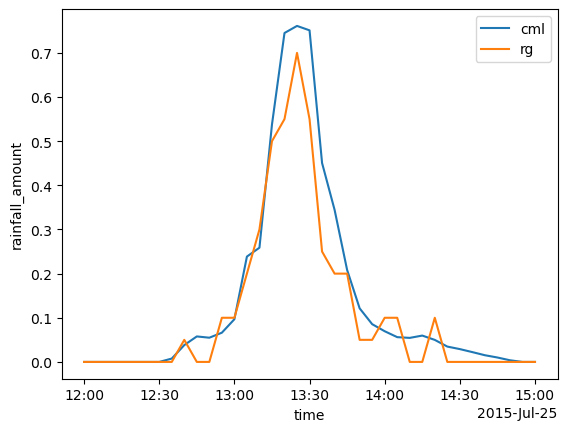

In [37]:
ds_cml.R.median(dim = 'obs_id').plot(label = 'cml')
ds_gauges.rainfall_amount.median(dim = 'station_id').plot(label = 'rg')
plt.legend()

In [38]:
from gcopula_sparaest import reconstruct_parameters

# Calculate correlation lengths for all timesteps

In [39]:
time_start = '2015-07-25T12:00' # 12:00
time_end = '2015-07-25T15:30' # 15:30
n_ests = 8# 8

### For rain gauges

In [177]:
n_ests = n_ests # use 8
cmod_midpoint_steps = {} # store data as timestep:[sim .. ]
seed = 4
np.random.seed(seed)
for time in tqdm(ds_cml.sel(time = slice(time_start, time_end)).time):
    cmod_midpoint_steps[time.values] = []
    for _ in range(n_ests):
        # Method 1: Midpoint
        # Calulate Copula model and marginal
        lin_yx = np.vstack((ds_gauges.sel(time = time).y.values, ds_gauges.sel(time = time).x.values)).T.astype(int)
        lin_prec = ds_gauges.sel(time = time).rainfall_amount.values
        
        if (lin_prec > 0).sum() >= 0: #
            cmod_midpoint = rmp.calculate_copula( 
                lin_yx,
                lin_prec*10,
                outputfile=None,
                covmods='exp',
                ntries=5,
                nugget=0.001,
            )
            cmod_midpoint_steps[time.values].append(cmod_midpoint)
        else:
            cmod_midpoint_steps[time.values].append(np.nan)
            
# get estimated range (for plotting)
cmod_midpoint_plot = {}
for time in tqdm(ds_cml.sel(time = slice(time_start, time_end)).time):
    cmod_midpoint_plot[time.values] = []
    for i in range(n_ests):
        if pd.isnull(cmod_midpoint_steps[time.values][i]):
            cmod_midpoint_plot[time.values].append(np.nan)
            
        else:
            cmod_midpoint_plot[time.values].append(float(cmod_midpoint_steps[time.values][i].split()[-1][4:-1]))
            
df_midpoint_rg = pd.DataFrame(cmod_midpoint_plot).T

100%|█| 37/37 [03:4
100%|█| 37/37 [00:0


### For all links

In [178]:
n_ests = n_ests # use 8
cmod_midpoint_steps = {} # store data as timestep:[sim .. ]
cmod_dereg_steps = {}

seed = 4
np.random.seed(seed)
for time in tqdm(ds_cml.sel(time = slice(time_start, time_end)).time):
    cmod_midpoint_steps[time.values] = []
    cmod_dereg_steps[time.values] = []
    for _ in range(n_ests):
        # Method 1: Midpoint
        # Calulate Copula model and marginal
        lin_yx = np.vstack((ds_cml.sel(time = time).y.values, ds_cml.sel(time = time).x.values)).T.astype(int)
        lin_prec = ds_cml.sel(time = time).R.values
        
        if (lin_prec > 0).sum() >= 8: # require at leat 8 observations (
            cmod_midpoint = rmp.calculate_copula( 
                lin_yx,
                lin_prec*10,
                outputfile=None,
                covmods='nug exp',
                ntries=5,
                nugget=0.001,
            )
            cmod_midpoint_steps[time.values].append(cmod_midpoint)


            # Prepare data for method 2 dereg.
            # first create geometry and fit copula model
            pos_x, pos_y = create_blocks_from_lines(np.hstack([
                ds_cml.sel(time = time).y_a.values.reshape(-1, 1),
                ds_cml.sel(time = time).y_b.values.reshape(-1, 1),
                ds_cml.sel(time = time).x_a.values.reshape(-1, 1),
                ds_cml.sel(time = time).x_b.values.reshape(-1, 1),
                ]), disc = 8)
            cml_yx_block = np.array([pos_y, pos_x]).transpose([1, 0, 2])
            lin_prec = ds_cml.sel(time = time).R.values
            cml_yx_block, lin_prec = cmlp.filter_nans_a(cml_yx_block, lin_prec)
            

            cmod_dereg = rmp.calculate_copula(
                cml_yx_block,
                lin_prec*10,
                outputfile=None,
                covmods="exp",
                ntries=5,
                nugget=float(cmod_midpoint.split('p')[0][0:5]),
                mode='block',
                maxrange = float(cmod_midpoint.split('p')[-1][1:-3]),
                minrange = 0.25, # 1/4 the below grid size
            )
            cmod_dereg_steps[time.values].append(cmod_dereg)
        else:
            cmod_midpoint_steps[time.values].append(np.nan)
            cmod_dereg_steps[time.values].append(np.nan)
            
# get estimated range (for plotting)
cmod_midpoint_plot = {}
cmod_dereg_plot = {}
for time in tqdm(ds_cml.sel(time = slice(time_start, time_end)).time):
    cmod_midpoint_plot[time.values] = []
    cmod_dereg_plot[time.values] = []
    for i in range(n_ests):
        if pd.isnull(cmod_midpoint_steps[time.values][i]):
            cmod_midpoint_plot[time.values].append(np.nan)
            cmod_dereg_plot[time.values].append(np.nan)
            
        else:
            cmod_midpoint_plot[time.values].append(float(cmod_midpoint_steps[time.values][i].split()[-1][4:-1]))
            cmod_dereg_plot[time.values].append(float(cmod_dereg_steps[time.values][i].split()[-1][4:-1]))
            
df_dereg = pd.DataFrame(cmod_dereg_plot).T
df_midpoint = pd.DataFrame(cmod_midpoint_plot).T

100%|█| 37/37 [6:27
100%|█| 37/37 [00:0


<Axes: >

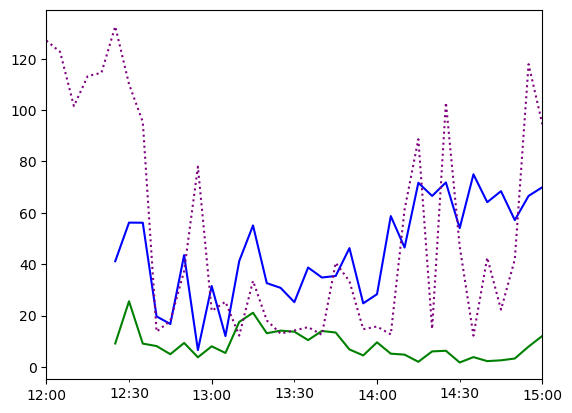

In [182]:
df_dereg.mean(axis = 1).rolling(window = 1, center = True, min_periods=1).mean().plot(color = 'green', linestyle= '-')
df_midpoint.mean(axis = 1).rolling(window = 1, center = True, min_periods=1).mean().plot(color = 'blue', linestyle= '-')
df_midpoint_rg.mean(axis = 1).rolling(window = 1, center = True, min_periods=1).mean().plot(color = 'purple', linestyle= 'dotted')

In [183]:
# # # uncomment to save again
fields_5min = [df_dereg, df_midpoint, df_midpoint_rg]
with open('/home/erlend/Downloads/fields_openmrg_variograms_mlp.pickle', 'wb') as handle:
    pickle.dump(fields_5min, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [40]:
# run top part of notebook (sample CMLs etc) before running this
with open(r'/home/erlend/Downloads/fields_openmrg_variograms_mlp.pickle', "rb") as input_file: 
    [df_dereg, df_midpoint, df_midpoint_rg] = pickle.load(input_file)

# Condition stochastic fields for all timesteps:

In [41]:
# må gange for å ikkje få problem med små gridstørrelser
# corr length of 5-10
# gridsize of approx 60x60

In [42]:
nfields = 200 # number of fields to generate
N = 70 # number of samples from conditioned fields and real field 
N_samples = 8 # number of random fields to estimate from (must be lower than nfields)

synthetic_gridsize_yx = domainsize[1:]
time_iterate = ds_cml.sel(time = slice(time_start, time_end)).time

In [189]:
# Condition and evaluate fields for MIDPOINT METHOD
copula_midpoint = {'gaussian_range_unconditioned': [], 'gaussian_range_conditioned': [], 'field_conditioned': []}
seed = 1
for time in time_iterate:
    if np.isnan(df_midpoint.loc[time.values]).any():
        copula_midpoint['gaussian_range_conditioned'].append(np.zeros(N_samples)*np.nan)
        copula_midpoint['field_conditioned'].append(
            np.zeros([nfields, synthetic_gridsize_yx[0], synthetic_gridsize_yx[1]])*np.nan) 
    else: 
        cml_prec = ds_cml.sel(time = time).R.values.ravel()

        # create nonlinear integrals for RM
        cml_yx = np.vstack(
            (
                ds_cml.sel(time = time).y_a.values,
                ds_cml.sel(time = time).x_a.values,
                ds_cml.sel(time = time).y_b.values,
                ds_cml.sel(time = time).x_b.values,
            )
        ).T.astype(int)
        cml_yx, cml_prec = cmlp.filter_nans_a(cml_yx, cml_prec)
        marginal = rmp.calculate_marginal(cml_prec*10) # kde is (supposedly) better with this *10, if you remove it: check backtransform under RM_processing

        # load estimated model, here use mean of all estimates
        cmod = '0.001 Nug(0.0) + 0.999 Exp(' + str(df_midpoint.loc[time.values].mean()) + ')'

        # condition fields
        nonlin_integrals = rmp.nl_integrals(cml_yx) 
        my_CMLModel = CMLModel(cml_prec, marginal, nonlin_integrals)

        CS = RMWS(
            my_CMLModel,
            domainsize=synthetic_gridsize_yx,
            covmod=cmod,
            nFields=nfields,
            cp=None,
            cv=None,
            le_cp=None,
            le_cv=None,
            optmethod="circleopt",
            minObj=0.4,
            maxbadcount=30,
            maxiter=100,
            pyfftwmode=True,
            seed=seed,
            tstep="aaa",
        )
        CS()
        final_fields = rmp.backtransform(CS.finalFields, marginal)
        del CS
        
#         # investigate the spatial structure of the final fields
#         ranges_from_field = [] 
#         for i in range(N_samples):
# #             x_min = np.min([ds_cml.x_a, ds_cml.x_b]).astype(int)
# #             x_max = np.max([ds_cml.x_a, ds_cml.x_b]).astype(int)
# #             y_min = np.min([ds_cml.y_a, ds_cml.y_b]).astype(int)
# #             y_max = np.max([ds_cml.y_a, ds_cml.y_b]).astype(int)

# #             [y_ind_a, y_ind_b], [x_ind_a, x_ind_b], radar_along_cmls = generate_cmls_grid_intersects(
# #                 np.random.randint(y_min, y_max, size=N),
# #                 np.random.randint(x_min, x_max, size=N),
# #                 np.ones(N)*0.01, # short lines so we stay inside grid size
# #                 np.array([final_fields[i, :, :]]),
# #             )
#             # sample above raingauges (midpoint should reveal underlying true corr length)
#             [y_ind_a, y_ind_b], [x_ind_a, x_ind_b], radar_along_cmls = generate_cmls_grid_intersects(
#                 ds_gauges.y.values,
#                 ds_gauges.x.values,
#                 np.ones(ds_gauges.y.size)*0.01, # short lines so we stay inside grid size
#                 np.array([final_fields[i, :, :]]),
#             )


#             # a and b is the same for points, thus we can just use that
#             lin_yx = np.vstack((y_ind_a.ravel(), x_ind_a.ravel())).T.astype(int)
#             lin_prec = radar_along_cmls.ravel()
            
#             # remove duplicates
#             unique_rows, unique_indices = np.unique(lin_yx, axis=0, return_index=True)
#             lin_yx = lin_yx[unique_indices, :]
#             lin_prec = lin_prec[unique_indices]
            
#             if (lin_prec.size > 20) and ((lin_prec > 0).sum()/lin_prec.size > 0.5):
#                 cmod = rmp.calculate_copula( 
#                     lin_yx,
#                     lin_prec*10,
#                     outputfile=None,
#                     covmods=["Exp"],
#                     ntries=6,
#                     nugget=0.001,

#                 )
#                 ranges_from_field.append(float(cmod.split()[-1][4:-1]))
#             else:
#                 ranges_from_field.append(np.nan)

#         # store statistics
#         copula_midpoint['gaussian_range_conditioned'].append(np.array(ranges_from_field))
        copula_midpoint['field_conditioned'].append(final_fields)     
    print(time.values)


2015-07-25T12:00:00.000000000
2015-07-25T12:05:00.000000000
2015-07-25T12:10:00.000000000
2015-07-25T12:15:00.000000000
2015-07-25T12:20:00.000000000
2015-07-25T12:25:00.000000000
2015-07-25T12:30:00.000000000
2015-07-25T12:35:00.000000000
2015-07-25T12:40:00.000000000
2015-07-25T12:45:00.000000000
2015-07-25T12:50:00.000000000
2015-07-25T12:55:00.000000000
2015-07-25T13:00:00.000000000
2015-07-25T13:05:00.000000000
2015-07-25T13:10:00.000000000
2015-07-25T13:15:00.000000000
2015-07-25T13:20:00.000000000
2015-07-25T13:25:00.000000000
2015-07-25T13:30:00.000000000
2015-07-25T13:35:00.000000000
2015-07-25T13:40:00.000000000
2015-07-25T13:45:00.000000000
2015-07-25T13:50:00.000000000
2015-07-25T13:55:00.000000000
2015-07-25T14:00:00.000000000
2015-07-25T14:05:00.000000000
2015-07-25T14:10:00.000000000
2015-07-25T14:15:00.000000000
2015-07-25T14:20:00.000000000
2015-07-25T14:25:00.000000000
2015-07-25T14:30:00.000000000
2015-07-25T14:35:00.000000000
2015-07-25T14:40:00.000000000
2015-07-25

In [190]:
copula_dereg = {'gaussian_range_unconditioned': [], 'gaussian_range_conditioned': [], 'field_conditioned': []}

# Condition and evaluate fields for DEREG METHOD
for time in time_iterate:
    if np.isnan(df_dereg.loc[time.values]).any():
        copula_dereg['gaussian_range_conditioned'].append(np.zeros(N_samples)*np.nan)
        copula_dereg['field_conditioned'].append(
            np.zeros([nfields, synthetic_gridsize_yx[0], synthetic_gridsize_yx[1]])*np.nan) 
        
    else: 
        cml_prec = ds_cml.sel(time = time).R.values.ravel()

        # create nonlinear integrals for RM
        cml_yx = np.vstack(
            (
                ds_cml.sel(time = time).y_a.values,
                ds_cml.sel(time = time).x_a.values,
                ds_cml.sel(time = time).y_b.values,
                ds_cml.sel(time = time).x_b.values,
            )
        ).T.astype(int)
        cml_yx, cml_prec = cmlp.filter_nans_a(cml_yx, cml_prec)
        marginal = rmp.calculate_marginal(cml_prec*10)# kde is (supposedly) better with this *10, if you remove it: check backtransform under RM_processing

        # load estimated model, here use mean of all estimates
        cmod = '0.001 Nug(0.0) + 0.999 Exp(' + str(df_dereg.loc[time.values].mean()) + ')'

        # condition fields
        nonlin_integrals = rmp.nl_integrals(cml_yx) 
        my_CMLModel = CMLModel(cml_prec, marginal, nonlin_integrals)

        CS = RMWS(
            my_CMLModel,
            domainsize=synthetic_gridsize_yx,
            covmod=cmod,
            nFields=nfields,
            cp=None,
            cv=None,
            le_cp=None,
            le_cv=None,
            optmethod="circleopt",
            minObj=0.4,
            maxbadcount=30,
            maxiter=100,
            pyfftwmode=True,
            seed=seed,
            tstep="aaa",
        )
        CS()
        final_fields = rmp.backtransform(CS.finalFields, marginal) 
        del CS

        # investigate the spatial structure of the final fields
#         ranges_from_field = [] 
#         for i in range(N_samples):
# #             x_min = np.min([ds_cml.x_a, ds_cml.x_b]).astype(int)
# #             x_max = np.max([ds_cml.x_a, ds_cml.x_b]).astype(int)
# #             y_min = np.min([ds_cml.y_a, ds_cml.y_b]).astype(int)
# #             y_max = np.max([ds_cml.y_a, ds_cml.y_b]).astype(int)

# #             [y_ind_a, y_ind_b], [x_ind_a, x_ind_b], radar_along_cmls = generate_cmls_grid_intersects(
# #                 np.random.randint(y_min, y_max, size=N),
# #                 np.random.randint(x_min, x_max, size=N),
# #                 np.ones(N)*0.01, # short lines so we stay inside grid size
# #                 np.array([final_fields[i, :, :]]),
# #             )
#             [y_ind_a, y_ind_b], [x_ind_a, x_ind_b], radar_along_cmls = generate_cmls_grid_intersects(
#                 ds_gauges.y.values,
#                 ds_gauges.x.values,
#                 np.ones(ds_gauges.y.size)*0.01, # short lines so we stay inside grid size
#                 np.array([final_fields[i, :, :]]),
#             )


#             # a and b is the same for points, thus we can just use that
#             lin_yx = np.vstack((y_ind_a.ravel(), x_ind_a.ravel())).T.astype(int)
#             lin_prec = radar_along_cmls.ravel()
#             unique_rows, unique_indices = np.unique(lin_yx, axis=0, return_index=True)
#             lin_yx = lin_yx[unique_indices, :]
#             lin_prec = lin_prec[unique_indices]
            
#             if (lin_prec > 0).sum()/lin_prec.size > 0.5:
#                 cmod = rmp.calculate_copula( 
#                     lin_yx,
#                     lin_prec*10,
#                     outputfile=None,
#                     covmods=["Exp"],
#                     ntries=6,
#                     nugget=0.001,
#                 )
#                 ranges_from_field.append(float(cmod.split()[-1][4:-1]))
#             else:
#                 ranges_from_field.append(np.nan)

        # store statistics
        #copula_dereg['gaussian_range_conditioned'].append(np.array(ranges_from_field))
        copula_dereg['field_conditioned'].append(final_fields) 
    print(time.values)


2015-07-25T12:00:00.000000000
2015-07-25T12:05:00.000000000
2015-07-25T12:10:00.000000000
2015-07-25T12:15:00.000000000
2015-07-25T12:20:00.000000000
2015-07-25T12:25:00.000000000
2015-07-25T12:30:00.000000000
2015-07-25T12:35:00.000000000
2015-07-25T12:40:00.000000000
2015-07-25T12:45:00.000000000
2015-07-25T12:50:00.000000000
2015-07-25T12:55:00.000000000
2015-07-25T13:00:00.000000000
2015-07-25T13:05:00.000000000
2015-07-25T13:10:00.000000000
2015-07-25T13:15:00.000000000
2015-07-25T13:20:00.000000000
2015-07-25T13:25:00.000000000
2015-07-25T13:30:00.000000000
2015-07-25T13:35:00.000000000
2015-07-25T13:40:00.000000000
2015-07-25T13:45:00.000000000
2015-07-25T13:50:00.000000000
2015-07-25T13:55:00.000000000
2015-07-25T14:00:00.000000000
2015-07-25T14:05:00.000000000
2015-07-25T14:10:00.000000000
2015-07-25T14:15:00.000000000
2015-07-25T14:20:00.000000000
2015-07-25T14:25:00.000000000
2015-07-25T14:30:00.000000000
2015-07-25T14:35:00.000000000
2015-07-25T14:40:00.000000000
2015-07-25

In [191]:
# # # uncomment to save again
fields_5min = [copula_midpoint, copula_dereg]
with open('/home/erlend/Downloads/fields_openmrg_mlp.pickle', 'wb') as handle:
    pickle.dump(fields_5min, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [43]:
# run top part of notebook (sample CMLs etc) before running this
with open(r'/home/erlend/Downloads/fields_openmrg_mlp.pickle', "rb") as input_file: 
    [copula_midpoint, copula_dereg] = pickle.load(input_file)

In [44]:
copula_midpoint['field_conditioned'] = np.array(copula_midpoint['field_conditioned'])
copula_dereg['field_conditioned'] = np.array(copula_dereg['field_conditioned'])

copula_midpoint['gaussian_range_conditioned'] = np.array(copula_midpoint['gaussian_range_conditioned'])
copula_dereg['gaussian_range_conditioned'] = np.array(copula_dereg['gaussian_range_conditioned'])


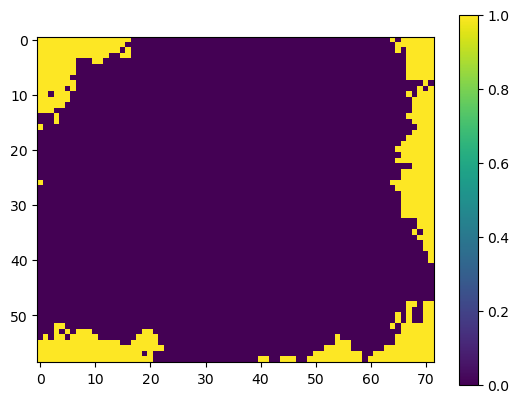

In [65]:
plt.imshow(np.nansum(copula_midpoint['field_conditioned'], axis = 0).var(axis = 0) > 1)
plt.colorbar()

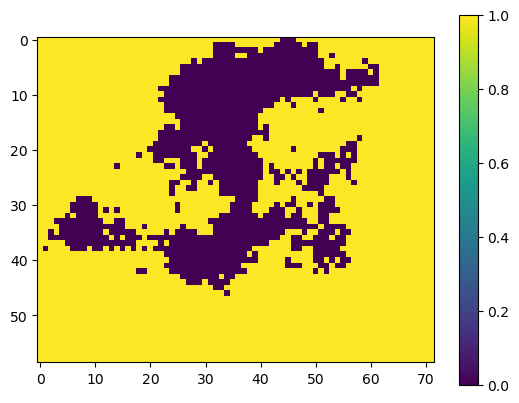

In [66]:
plt.imshow(np.nansum(copula_dereg['field_conditioned'], axis = 0).var(axis = 0) > 1)
plt.colorbar()

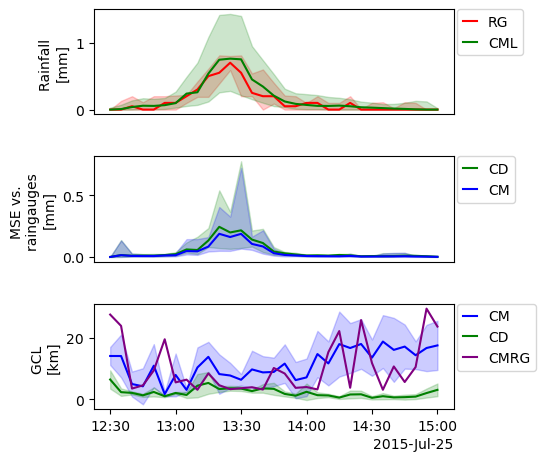

In [69]:
time_plot_start = '2015-07-25T12:30' #13.30
time_plot_end =   '2015-07-25T15:00' # 17.30
time_t1 = np.argmax((time_iterate == time_iterate.sel(time = time_plot_start, method = 'nearest')).values)
time_t2 = np.argmax((time_iterate == time_iterate.sel(time = time_plot_end, method = 'nearest')).values) + 1 #(to include last timestep)
time_plot = time_iterate.sel(time =slice(time_plot_start, time_plot_end))


fig, ax = plt.subplots(3, 1,figsize =(6, 5), sharex = True)
plt.subplots_adjust(left=0.2, right=0.8, bottom=0.1, top=0.9, wspace=0.2, hspace=0.4)

# Mean ammounts
mean = ds_gauges.sel(time = time_plot).rainfall_amount.median(dim = 'station_id').values
upper =  ds_gauges.sel(time = time_plot).rainfall_amount.quantile(q = 0.9, dim = 'station_id').values
lower =  ds_gauges.sel(time = time_plot).rainfall_amount.quantile(q = 0.1, dim = 'station_id').values
ax[0].plot(time_plot, mean, label='RG', color = 'red')
ax[0].fill_between(time_plot, lower, upper, color= 'red', alpha = 0.2)

mean = ds_cml.sel(time = time_plot).R.median(dim = 'obs_id').values
upper = ds_cml.sel(time = time_plot).R.quantile(q = 0.9, dim = 'obs_id').values
lower = ds_cml.sel(time = time_plot).R.quantile(q = 0.1, dim = 'obs_id').values
ax[0].plot(time_plot, mean, label='CML', color = 'green')
ax[0].fill_between(time_plot, lower, upper, color= 'green', alpha = 0.2)

ax[0].tick_params(axis='x', which='both', bottom=False, top=False,labelbottom=False) 
ax[0].set_ylabel('Rainfall \n[mm]', fontsize=10)
ax[0].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, handlelength=1)

# RMSE gauges
rmse_dereg = []
rmse_midpoint = []
for gauge_i in range(ds_gauges.station_id.size):
    # dereg
    pred = copula_dereg['field_conditioned'][time_t1:time_t2, :, ds_gauges.y.values[gauge_i], ds_gauges.x.values[gauge_i]]
    ref = ds_gauges.sel(time = time_plot).isel(station_id = gauge_i).rainfall_amount.values
    rmse = []
    for sim_i in range(pred.shape[1]):
        rmse.append((pred[:, sim_i] - ref)**2)
    rmse = np.array(rmse).mean(axis = 0)
    rmse_dereg.append(rmse)
    # midpoint
    pred = copula_midpoint['field_conditioned'][time_t1:time_t2, :, ds_gauges.y.values[gauge_i], ds_gauges.x.values[gauge_i]]
    ref = ds_gauges.sel(time = time_plot).isel(station_id = gauge_i).rainfall_amount.values
    rmse = []
    for sim_i in range(pred.shape[1]):
        rmse.append((pred[:, sim_i] - ref)**2)
    rmse = np.array(rmse).mean(axis = 0)
    rmse_midpoint.append(rmse)
    
rmse_dereg = np.array(rmse_dereg)
rmse_midpoint = np.array(rmse_midpoint)
mean = np.mean(rmse_dereg, axis = 0)
min_ = np.min(rmse_dereg, axis = 0)
max_ = np.max(rmse_dereg, axis = 0)
ax[1].fill_between(time_plot, min_, max_, color= 'green', alpha = 0.2)
ax[1].plot(time_plot, mean, color = 'green', label = 'CD')

mean = np.mean(rmse_midpoint, axis = 0)
min_ = np.min(rmse_midpoint, axis = 0)
max_ = np.max(rmse_midpoint, axis = 0)
ax[1].fill_between(time_plot, min_, max_, color= 'blue', alpha = 0.2)
ax[1].plot(time_plot, mean, color = 'blue', label = 'CM')
ax[1].tick_params(axis='x', which='both', bottom=False, top=False,labelbottom=False) 
ax[1].set_ylabel('MSE vs. \nraingauges \n[mm]', fontsize=10)
ax[1].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, handlelength=1)

# gaussian correlation length, 
mid_plot = df_midpoint.loc[time_plot_start:time_plot_end]*(gridsize/1000)
mid_plot_rg = df_midpoint_rg.loc[time_plot_start:time_plot_end]*(gridsize/1000)
dereg_plot = df_dereg.loc[time_plot_start:time_plot_end]*(gridsize/1000)

mid_plot.mean(axis = 1).to_xarray().plot(ax=ax[2], label = 'CM', color = 'blue')
dereg_plot.mean(axis = 1).to_xarray().plot(ax=ax[2], label = 'CD', color = 'green')
mid_plot_rg.mean(axis = 1).to_xarray().plot(ax=ax[2], label = 'CMRG', color = 'purple')

ax[2].fill_between(time_plot, mid_plot.mean(axis = 1).values - mid_plot.std(axis = 1), 
                   mid_plot.mean(axis = 1).values + mid_plot.std(axis = 1), color='blue', alpha = 0.2)
ax[2].fill_between(time_plot, dereg_plot.mean(axis = 1).values - dereg_plot.std(axis = 1), 
                   dereg_plot.mean(axis = 1).values + dereg_plot.std(axis = 1), color='green', alpha = 0.2)
ax[2].set_xlabel('')
ax[2].set_ylabel('GCL \n[km]', fontsize=10)
ax[2].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, handlelength=1, fontsize=10)
#ax[2].set_ylim(0, 30)

plt.savefig('/home/erlend/Downloads/result_openmrg.png', format = 'png')
